In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv("Tornadoes_SPC_1950to2015.csv")

In [5]:
df.head()

om    yr  mo  dy       date      time  tz  st  stf  stn  ...  fat  loss  \
0   1  1950   1   3   1/3/1950  11:00:00   3  MO   29    1  ...    0   6.0   
1   2  1950   1   3   1/3/1950  11:55:00   3  IL   17    2  ...    0   5.0   
2   3  1950   1   3   1/3/1950  16:00:00   3  OH   39    1  ...    0   4.0   
3   4  1950   1  13  1/13/1950   5:25:00   3  AR    5    1  ...    1   3.0   
4   5  1950   1  25  1/25/1950  19:30:00   3  MO   29    2  ...    0   5.0   

   closs   slat   slon   elat   elon  len  wid  fc  
0    0.0  38.77 -90.22  38.83 -90.03  9.5  150   0  
1    0.0  39.10 -89.30  39.12 -89.23  3.6  130   0  
2    0.0  40.88 -84.58   0.00   0.00  0.1   10   0  
3    0.0  34.40 -94.37   0.00   0.00  0.6   17   0  
4    0.0  37.60 -90.68  37.63 -90.65  2.3  300   0  

[5 rows x 22 columns]

In [6]:
# Checking for missing data
df.isna().sum()

om       0
yr       0
mo       0
dy       0
date     0
time     0
tz       0
st       0
stf      0
stn      0
mag      0
inj      0
fat      0
loss     0
closs    0
slat     0
slon     0
elat     0
elon     0
len      0
wid      0
fc       0
dtype: int64

In [7]:
df_2007 = df[df['yr'] > 2006]
df_2007.corr()['mag'].sort_values()

stf     -0.077061
mo      -0.061244
slat    -0.037377
elon    -0.014043
yr       0.006084
om       0.014309
stn      0.018816
dy       0.033197
elat     0.060043
closs    0.096944
slon     0.150052
loss     0.157717
inj      0.188163
fat      0.193701
len      0.556546
wid      0.602964
mag      1.000000
tz            NaN
fc            NaN
Name: mag, dtype: float64

In [8]:
# Dropping unnecesary columns. Dropping closs as well, since there is too much data missing to even try any feature engineering
# and correlation to label is very low even for data after 2007 as seen in the cell above.
df.drop(['om', 'date', 'fc', 'stn', 'stf', 'tz', 'closs'], axis=1, inplace=True)

In [9]:
# Extracting hour and minute from the time column
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].apply(lambda x: x.hour)
df['minute'] = df['time'].apply(lambda x: x.minute)
df.drop('time', axis=1, inplace=True)

## Exploratory Data Analysis

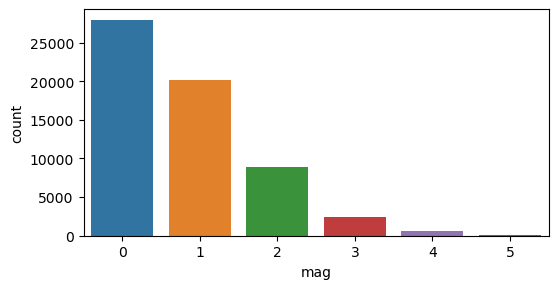

In [10]:
# Count of tornados per magnitude class
plt.figure(figsize=(6,3), dpi=100)
sns.countplot(data=df, x='mag');

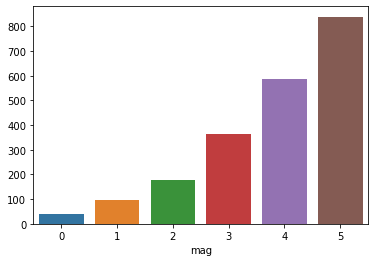

In [11]:
# Average tornado width by magnitude
data = df.groupby('mag').mean()['wid']
sns.barplot(x=data.index, y=data.values);

<AxesSubplot:xlabel='mag', ylabel='fat'>

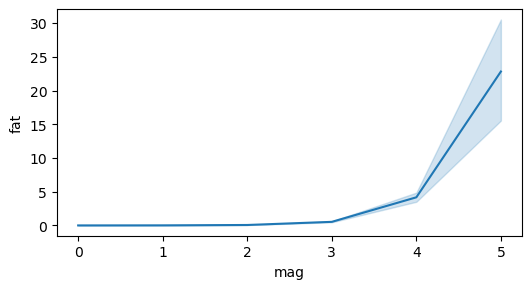

In [12]:
# Lineplot of fatalities per tornado magnitude class
plt.figure(figsize=(6,3), dpi=100)
sns.lineplot(data=df, x='mag', y='fat')

In [13]:
#Top 5 states with most F5/EF5 tornadoes
df[df['mag'] >= 5]['st'].value_counts().head()

OK    8
AL    7
TX    6
IA    6
KS    6
Name: st, dtype: int64

In [14]:
#Top 5 states with most losses
df.groupby(df['st'])['loss'].sum().nlargest()

st
TX    12933.06
OK    10054.41
AL     8889.27
MO     7591.17
FL     7351.86
Name: loss, dtype: float64

In [15]:
#Top 5 states with most fatalities
df.groupby(df['st'])['fat'].sum().nlargest()

st
AL    624
TX    579
MS    455
OK    429
AR    391
Name: fat, dtype: int64

In [16]:
# Pearson correlation to magnitude feature
df.corr()['mag'].sort_values()

yr       -0.309027
elon     -0.071248
minute   -0.051889
mo       -0.050574
hour     -0.035803
slat     -0.017290
dy       -0.010877
elat      0.084820
loss      0.122979
slon      0.136228
fat       0.197807
inj       0.223765
wid       0.424948
len       0.437395
mag       1.000000
Name: mag, dtype: float64

In [17]:
# Spearman correlation to magnitude feature
# Some features have a much higher monotonic relationship to Magnitude
df.corr(method='spearman')['mag'].sort_values()

yr       -0.314312
mo       -0.083142
minute   -0.063745
slat     -0.027070
hour     -0.012307
dy       -0.010162
elon      0.015407
elat      0.037015
slon      0.175188
fat       0.240217
wid       0.395750
inj       0.418237
len       0.482094
loss      0.599853
mag       1.000000
Name: mag, dtype: float64

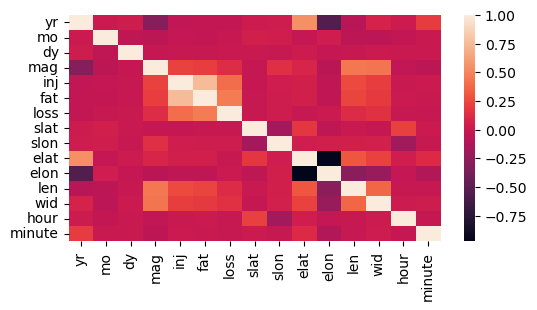

In [18]:
plt.figure(figsize=(6,3), dpi=100)
sns.heatmap(df.corr());

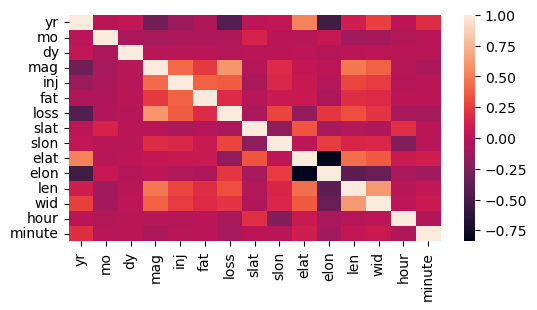

In [19]:
plt.figure(figsize=(6,3), dpi=100)
sns.heatmap(df.corr(method='spearman'));

## Data Preparation

In [20]:
df[df['loss'] > 0].groupby('mag')['loss'].mean()

mag
0      1.704386
1      2.907495
2      4.163244
3      7.049313
4     19.833918
5    151.135472
Name: loss, dtype: float64

In [21]:
df[df['wid'] > 0].groupby('mag')['wid'].mean()

mag
0     42.133048
1     95.864261
2    175.954653
3    364.377547
4    588.644248
5    839.067797
Name: wid, dtype: float64

In [22]:
df[df['len'] > 0].groupby('mag')['len'].mean()

mag
0     1.024730
1     3.198588
2     6.959467
3    14.963802
4    27.560850
5    39.007797
Name: len, dtype: float64

In [23]:
# Converting the rows with value 0 to NaN
df['loss'] = df['loss'].replace(0, np.nan)
# Then filling those values with the mean given its tornado magnitude
df['loss'] = df.groupby('mag')['loss'].transform(lambda x: x.fillna(x.mean()))

In [24]:
# Doing the same for the other 3 features: len, wid and closs
df['len'] = df['len'].replace(0, np.nan)
df['len'] = df.groupby('mag')['len'].transform(lambda x: x.fillna(x.mean()))

In [25]:
df['wid'] = df['wid'].replace(0, np.nan)
df['wid'] = df.groupby('mag')['wid'].transform(lambda x: x.fillna(x.mean()))

## Modeling

In [26]:
# Dummy variables for discrete features
df = pd.get_dummies(df, prefix=['st'], columns=['st'], drop_first=True)

In [27]:
y = df['mag']
X = df.drop('mag', axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=True, random_state=101, stratify=y)

In [29]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [30]:
xgb = XGBClassifier(random_state=101)
rfc = RandomForestClassifier(random_state=101)
lgbm = LGBMClassifier(random_state=101)
models = [xgb, rfc, lgbm]

for model in models:
    model.fit(scaled_X_train, y_train)
    y_pred = model.predict(scaled_X_test)
    print(f'{type(model).__name__}')
    print(classification_report(y_test, y_pred, zero_division=1))

C:\Users\alexi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:08:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     19553
           1       0.67      0.78      0.72     14155
           2       0.56      0.48      0.52      6247
           3       0.48      0.35      0.40      1688
           4       0.46      0.29      0.36       396
           5       0.39      0.17      0.24        41

    accuracy                           0.76     42080
   macro avg       0.58      0.49      0.52     42080
weighted avg       0.76      0.76      0.75     42080

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     19553
           1       0.66      0.79      0.72     14155
    

In [542]:
# Moving forward with LGBM model
# Grid search for hyperparameter tuning
param_grid = {
    'boosting_type': ['gbdt', 'rf', 'dart', 'goss'],
    'num_iterations': [10, 100, 500, 1000],
    'learning_rate': [0.05, 0.5, 0.99]
}

base_lgbm = LGBMClassifier(random_state=101)

grid_model = GridSearchCV(base_lgbm, param_grid)

In [543]:
grid_model.fit(scaled_X_train, y_train)

C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserW

GridSearchCV(estimator=LGBMClassifier(random_state=101),
             param_grid={'boosting_type': ['gbdt', 'rf', 'dart', 'goss'],
                         'learning_rate': [0.05, 0.5, 0.99],
                         'num_iterations': [10, 100, 500, 1000]})

In [544]:
grid_model.best_params_

{'boosting_type': 'dart', 'learning_rate': 0.05, 'num_iterations': 500}

In [545]:
final_model = LGBMClassifier(boosting_type='dart', learning_rate=0.05, num_iterations=500)

In [546]:
final_model.fit(scaled_X_train, y_train)

C:\Users\alexi\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='dart', learning_rate=0.05, num_iterations=500)

In [547]:
preds = final_model.predict(scaled_X_test)

In [548]:
print(classification_report(y_test, preds, zero_division=1))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     19553
           1       0.67      0.81      0.73     14155
           2       0.58      0.49      0.53      6247
           3       0.52      0.34      0.41      1688
           4       0.48      0.28      0.35       396
           5       0.53      0.22      0.31        41

    accuracy                           0.76     42080
   macro avg       0.62      0.50      0.54     42080
weighted avg       0.76      0.76      0.76     42080



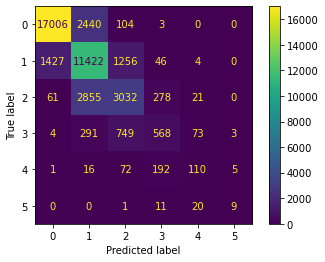

In [551]:
ConfusionMatrixDisplay.from_estimator(final_model, scaled_X_test, y_test)

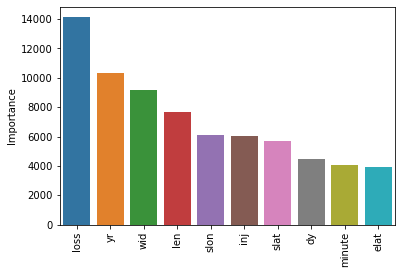

In [555]:
# Looking at the top 10 most important features
feats = pd.DataFrame(index=X.columns, data=final_model.feature_importances_, columns=['Importance'])
important_feats = feats.sort_values('Importance', ascending=False).head(10)
sns.barplot(data=important_feats, x=important_feats.index, y='Importance')
plt.xticks(rotation=90);